# CS-E4895: Gaussian Processes (2023)

# Lab exercise #3: Variational inference for GP classification with Tensorflow

## Learning objectives

After completing this lab exercise, you should be able to:
- Implement variational inference for GP classification and hyperparameter selection
- Know how to apply an automatic differentiation framework, such as Tensorflow, in the GP context

**/!\ Important Notes /!\**

* In the first part of this assignment, we will use an automatic differentiation framework to optimize the ELBO objective that arises in variational inference. Most standard optimization methods require access to the gradients of the optimized function, and if you were able to derive them by hand for this particular task, you could optimize using standard numpy/scipy. Nowadays, however, these automatic differentiation frameworks make things quite a lot easier, providing easy gradients and integrates them with different standard optimizers. This assignment is designed with Tensorflow, but if you wish, you can try implementing everything with a different framework, such as Pytorch or Jax (we suggest to stick with Tensorflow unless you feel sure about yourself). 
* All exercises must be solved using only basic mathematical operations (exp, erf, ...) and linear algebra routines (solve, matrix-vector products, ...)
* Common gotcha: getting the shape of your arrays wrong e.g. (N, 1) vs (1, N) vs (N,); check that all your functions get and return arrays of the correct shapes!

**A mini tutorial on automatic differentiation**

When using an automatic differentiation framework to optimize a function $f: \theta \to f(\theta)$, the variable $\theta$ and/or the operations mapping from $\theta$ to $f(\theta)$ must be defined using operators from the framework.

For example to optimize $e^{\theta}+e^{-\theta}$ with respect to $\theta$ with tensorflow, you need to proceed as follows: (See tutorial on gradient calculation in tensorflow: https://www.tensorflow.org/api_docs/python/tf/GradientTape)

In [1]:
#! python -m pip install tensorflow==2.9.0
#import tensorflow as tf
#print(tf.__version__)

In [2]:
#! python -m pip uninstall --yes tensorflow

In [3]:
import tensorflow as tf

# define the theta variable
theta = tf.Variable(1.0, dtype=tf.float64)

# define the function
f = lambda x: tf.exp(x) + tf.exp(-x) # note the use of the tf.exp operation (not np.exp)

# run the optimization
for t in range(1000):
    # at each step, compute the gradients
    with tf.GradientTape() as tape:
        tape.watch(theta)
        loss = f(theta)
    
    gradient = tape.gradient(loss, theta)
    
    # apply the variable update (gradient descent)
    theta.assign(theta - 0.01*gradient)
    
    if t % 100 == 0:
        print(t, theta)

print(tf.__version__)

0 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.976495976127124>
100 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.11997260765615987>
200 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.015891416802624455>
300 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.00210746772964796>
400 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=0.0002794913296214945>
500 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3.7066015766512994e-05>
600 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=4.91567854916927e-06>
700 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=6.519151061083718e-07>
800 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=8.645669185832985e-08>
900 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1.146584808250585e-08>
2.11.0


In [4]:
%matplotlib inline
import numpy as np
import math
import matplotlib.pyplot as plt

# Variational inference for Gaussian Process Classification (6 points)

We are interested in the problem of Gaussian Process classification. 

We have some data $\mathcal{D} = \left\lbrace {\bf x}_n, y_n \right\rbrace_{n=1}^N$, with $y_n \in \{-1,1\}$.

We want to perform inference in the following generative model:
$$
\begin{align*}
f(\cdot) &\sim GP(0, k) \\
f_n &= f({\bf x}_n) \qquad &&(f_n\in \mathbb{R}) \\
\theta_n &= \phi(f_n) \qquad &&(\theta_n\in (0, 1)) \\
\{-1,1\} \ni y_n  &\sim \text{Bernoulli}(p=\theta_n)
\end{align*}
$$
with $\phi$ the normal cumulative distribution function $\phi(x)=\int_{-\infty}^x {\cal N}(u; 0,1)\,{\rm d}u$.

We can compactly write the likelihood as
$$ p(y_n|f(\cdot),{\bf x}_n) = p(y_n|f_n) = \phi(y_n * f_n).$$


We will here use a Squared Exponential kernel, with two parameters: lengthscale $\ell$ and variance $\sigma^2$.


The posterior is $p({\bf f}|{\bf y}) \propto p({\bf y}|{\bf f})p({\bf f})$ is intractable, hence we resort to an approximate inference scheme called variational inference.

This turns inference into optimization. We optimize the distance $d(q) = \operatorname{KL}[q({\bf f})\|p({\bf f}|{\bf y})] \geq 0$, with respect to a distribution $q({\bf f})$

We parameterize $q$ through the mean vector $m$ and the Cholesky factor of the covariance $L$: i.e. $q({\bf f})={\cal N}({\bf f}|m, S=LL^\top)$

In practice we optimize the ELBO:
$${\cal L}(q) = \log p({\bf y})-d(q) = 
\underbrace{\mathbb{E}_q\big[ \log p({\bf y}|{\bf f}) \big]}_{\text{VE}} 
- \underbrace{\operatorname{KL}[q({\bf f})\|p({\bf f})]}_{\text{KL}}$$

We split the ELBO into two terms
* variational expectations (VE), or data fit term
* Kullback-Leibler (KL) from prior to approximate posterior, or regularization term


### Task 1a: KL divergence (1 point)

For a prior $p({\bf f})={\cal N}({\bf f}|0,K)$ and a variational distribution $q({\bf f})={\cal N}({\bf f}|m, S=LL^\top)$, compute the KL divergence $\operatorname{KL}[q({\bf f})\|p({\bf f})]$


You can use the formula:
$$
\begin{align*}
&\operatorname{KL}\left[\mathcal{N}(\mu_0,\Sigma_0) \| \mathcal{N}(\mu_1,\Sigma_1)\right] \\ 
 &= \frac{1}{2}\left(
    \operatorname{tr}\left(\Sigma_1^{-1}\Sigma_0\right) +
    \left(\mu_1 - \mu_0\right)^\top \Sigma_1^{-1}\left(\mu_1 - \mu_0\right) - k +
    \ln\frac{|\Sigma_1|}{|\Sigma_0|}
  \right),\; \text{(source: Wikipedia)}\\
  &= \dots \quad \text{ (Bonus: can you fill the gap?)}\\
    &=
  \frac{1}{2}\left(
    \sum_{ij} (L_1^{-1}L_0)^2_{ij} +
    \|L_1^{-1}\left(\mu_1 - \mu_0\right)\|^2 - k + 2\sum_{i}
    \big(\ln |L_{1,ii}|- \ln|L_{0,ii}|\big)
  \right),
  \end{align*}
  $$
where we have adapted it to the (mean, Cholesky) parameterization of the multivariate Gaussian distributions, i.e., $\Sigma_0 = L_0 L_0^\top$ and $\Sigma_1 = L_1 L_1^\top$.

#### Important note
In the last line of the equation above we simplified the computation of the log-determinant to a sum over the logarithms of the diagonal elements. This is specific to the parameterization using Cholesky factors of the covariances, which implies that $L_0$ and $L_1$ are *lower-triangular* matrices with non-negative elements on the diagonal! If not, we cannot expect this function to perform correctly. In this function, you can assume that the inputs are valid Cholesky factors, but later on we will need to ensure this explicitly. 

In [5]:
def KL(m0, L0, m1, L1):
    """ returns the KL divergence between N(m0, S0) and N(m1, S1)
    
    arguments:
    m0, m1   -- N × 1, mean vector
    L0, L1   -- N × N, Cholesky factor of a covariance matrix 
    returns a scalar
    """
    # numpy implementation
    #k = m0.size # k is the dimension
    #firstSum = np.sum(np.square(np.linalg.inv(L1) @ L0)) 
    #norm = np.linalg.norm(np.linalg.inv(L1) @ (m1-m0)) ** 2
    #secondSum = 2 * np.sum(np.log(np.abs(np.diag(L1))) - np.log(np.abs(np.diag(L0)))) 
    #return (1/2) * (firstSum + norm - k + secondSum) 
    
    #print("KL shape")
    #print(m0.shape)
    #print(m1.shape)
    #print(L0.shape)
    #print(L1.shape)
    ###
    
    # MODEL SOLUTION #
    term1 = tf.reduce_sum(tf.square(tf.linalg.solve(L1, L0)))
    term2 = tf.reduce_sum(tf.square(tf.linalg.solve(L1, (m1-m0))))
    k = tf.cast(tf.shape(L0)[0], tf.float64)
    term3inner = tf.math.log(tf.abs(tf.linalg.diag_part(L1))) - tf.math.log(tf.abs(tf.linalg.diag_part(L0)))
    return 0.5 * (term1 + term2 - k + 2 * tf.reduce_sum(term3inner))
    ##################
    
    #k = m0.shape[0] # k is the dimension
    #firstSum = tf.reduce_sum(tf.square(tf.linalg.triangular_solve(L1, L0))) 
    #norm = tf.norm(tf.linalg.triangular_solve(L1, (m1-m0))) ** 2
    #secondSum = 2 * tf.reduce_sum(tf.math.log(tf.abs(tf.linalg.diag_part(L1))) - tf.math.log(tf.abs(tf.linalg.diag_part(L0)))) 
    #print(((1/2) * (firstSum + norm - k + secondSum)).shape)
    #print("KL ends")
    #return (1/2) * (firstSum + norm - k + secondSum)
    ###############################################
    # ------- insert code here -------------------
    ###############################################



Let's check that the KL is coded properly.

For instance, noting $q_0(f) = N(f|0, I)$ and $q_1(f) = N(f|0, 2I)$, 
we should have:
* $\operatorname{KL}[q_0\|q_0] = 0$
* $\operatorname{KL}[q_0\|q_1] > 0$ 



In [6]:
def test_KL(K = 10):
    m_0 = np.random.randn(K, 1)
    m_1 = np.random.randn(K, 1)
    L_0 = np.tril(np.random.randn(K, K)) + 4*np.eye(K)# Cholesky matrices should be lower-triangular
    L_1 = np.tril(np.random.randn(K, K)) + 4*np.eye(K)# with positive elements on the diagonal
    
    assert abs(KL(m_0, L_0, m_0, L_0)) < 1e-10  # approx. == 0
    assert KL(m_0, L_0, m_1, L_1) > 0

    #print(KL(m_0, L_0, m_0, L_0))
    #print(KL(m_0, L_0, m_1, L_1))

test_KL()

### Task 1b: Variational expectations (1 point)

To compute the variational expectations $\mathbb{E}_{q(f_n)}\big[\log p(y_n|f_n)\big]$, we first need to compute the marginal distribution $q(f_n)$ and then compute the expectation.


In [7]:
def q_marginals(m, L):
    """ returns the vectors of marginal means and marginal variances
    i.e, the means and variances of q(f_n)
    
    Hint: You may want to use the tf.reduce_sum
    
    arguments:
    m   -- N × 1, mean vector
    L   -- N × N, Cholesky factor of a covariance matrix 
    returns two N × 1 vectors
    """
    # MODEL SOLUTION #
    v = tf.reshape(tf.linalg.diag_part(tf.matmul(L, L, transpose_b = True)), (-1, 1))
    return m, v
    ##################
    
    ###############################################
    # ------- insert code here -------------------
    ###############################################

    # compute marginal mean
    #marginal_mean = tf.reshape(m, [-1, 1]) 
    
    # compute marginal variance
    #marginal_variance = tf.reshape(tf.reduce_sum(tf.square(L), axis=0), [-1, 1])
    #print("q marginal starts")
    #print(m.shape)
    #print(L.shape)
    #print(marginal_mean.shape)
    #print(marginal_variance.shape)
    #print("q marginal ends")
    # return marginal_mean, marginal_variance

In [8]:
def phi(x):
    r""" Cumulative distribution function for the standard normal distribution 
    Hint: you may want to use the error function. (tf.math.erf if using tensorflow)
    Hint 2: You may want to use a small epsilon parameter to ensure that the output 
            is strictly between 0 and 1

    phi(x) = int_{-\infty, x} N(u| 0, 1) du    
    """
    ###############################################
    # ------- insert code here -------------------
    ###############################################
    # epsilon = 1e-10 # A small value to avoid division by zero
    #print("phi starts")
    #print(x.shape)
    #print((0.5 * (1.0 + tf.math.erf(x / math.sqrt(2.0))) + epsilon).shape)
    #print("phi ends")
    
    # MODEL SOLUTION #
    jitter= 1e-3
    return 0.5 * (1.0 + tf.math.erf(x/np.sqrt(2))) * (1- 2 * jitter) + jitter
    ##################
    
    #return 0.5 * (1.0 + tf.math.erf(x / math.sqrt(2.0))) + epsilon

def classif_log_likelihood(f, y):
    """ log p(y|f) for classification using the normal cdf 
        log p(y|f) = log phi(y * f)
        
    Arguments:
    f -- The GP value at the observation
    y -- The observed value of y, either -1 or 1
    """
    ###############################################
    # ------- insert code here -------------------
    ###############################################
    #return tf.log(phi(f * y))
    #print("classif starts")
    #print(f.shape)
    #print(y.shape)
    #print(phi(f*y).shape)
    #print("classif ends")
    return tf.math.log(phi(f * y)) # same as solution

The next function is given to you.

It approximates $\mathbb{E}_{q(f_n)}\big[\log p(y_n|f_n)\big]$ via [Gauss-Hermite quadrature](https://en.wikipedia.org/wiki/Gauss%E2%80%93Hermite_quadrature).

In [9]:
def expected_log_likelihood(
    means, mvars, llh, y, n_gh=20):
    """ returns the expected log likelihood terms
    
    E_q(f_n)[log p(y_n|f_n)]
    
    This is a quadrature approximation, 
    turning the integral into a sum.
        
    arguments:
    means  -- N × 1, vector of means
    mvars  -- N × 1, vector of marginal variances
    llh    -- log likelihood function
    y      -- N × 1, vector of observed labels
    """
    z, dz = np.polynomial.hermite.hermgauss(n_gh)
    weights = (dz / np.sqrt(np.pi)).reshape(1, -1) # 1 × n_gh
    #print("expected log starts")
    #print(means.shape)
    #print(mvars.shape)
    #print(y.shape)
    #print(tf.reshape(z, [1, -1]).shape)
    #print("Ends here")
    # inputs = means + np.sqrt(2) * tf.sqrt(mvars) * tf.reshape(z, [1, -1]) # N × n_gh
    inputs = means + np.sqrt(2) * tf.sqrt(mvars) * z.reshape([1, -1])
    llh_quad = weights * llh(inputs, y) # N × n_gh
    #print(tf.reduce_sum(llh_quad, axis=1).shape)
    return tf.reduce_sum(llh_quad, axis=1) # N,

### Task 1c: ELBO (1 point)

We are now ready to implement the ELBO as the difference between the variational expectations and the KL divergence:

$${\cal L}(q) = 
\underbrace{\mathbb{E}_q\big[ \log p({\bf y}|{\bf f}) \big]}_{\text{VE}} 
- \underbrace{\operatorname{KL}[q({\bf f})\|p({\bf f})]}_{\text{KL}}$$




In [10]:
def elbo(m_p, L_p, m_q, L_q, y):
    """ returns ELBO
    ℒ = ∑ₙ₌₁ᴺ 𝔼_q(fₙ)[log p(yₙ|fₙ)] - KL[q(f)∥p(f)]
        
    (See slides of lecture 5 for closed-form solution)
    
    arguments:
    L_p, L_q  -- N × N, Cholesky factors of the covariances of p and q
    m_p, m_q  -- N × 1, mean vector of p and q
    returns: a scalar
    """
    #print("elbo starts")
    #print(m_p.shape)
    #print(L_p.shape)
    #print(m_q.shape)
    #print(L_q.shape)
    #print(y.shape)
    
    m_q, v_q = q_marginals(m_q, L_q)
    VE = tf.reduce_sum(expected_log_likelihood(m_q, v_q, classif_log_likelihood, y, n_gh=20))
    KL_div = KL(m_q, L_q, m_p, L_p)
    #print((VE-KL_div).shape)
    #print("ends")
    #print((VE - KL_div).shape)
    return VE - KL_div
    ###############################################
    # ------- insert code here -------------------
    ###############################################



### Task 1d: Kernel & inference as optimization (1 point)

We are now ready to optimize the ELBO. We will first load some data and select a subset of it for the full VGP inference. Later on, we will do inference using the entire data set with sparse variational GPs. 

N = 50
(50, 2)
(50, 1)


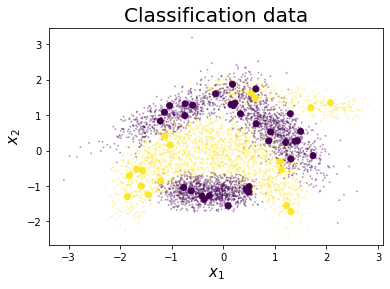

In [11]:
# Loading the data

import csv
XY = []
with open("banana.csv") as csvfile:
    reader = csv.reader(csvfile, quoting=csv.QUOTE_NONNUMERIC) # change contents to floats
    for row in reader: # each row is a list
        XY.append(row)
XY = np.array(XY)

# Here we select a subset of the data. (remember, computation scales as N^3)
np.random.seed(42)
np.random.shuffle(XY)
N = 50
X, Y = XY[:N,:-1], XY[:N,-1:]
Y = (Y-1.5) * 2 # to be in {-1, 1}
N = X.shape[0]

print("N =", N)
print(X.shape)
print(Y.shape)
# Plotting the data

plt.scatter(XY[:,0], XY[:,1], c=XY[:,2], s=1, alpha=0.3)
plt.scatter(X[:,0], X[:,1], c=Y)
plt.xlabel('$x_1$', fontsize=15)
plt.ylabel('$x_2$', fontsize=15)
plt.title('Classification data', fontsize=20);

#### Implementing the kernel
To fully specify the model, we need the prior covariance $K_p = K_{\bf ff}$ and its Cholesky factor $L_p = chol(K_{\bf ff})$. As usual, the prior mean is zero. Your task here is to implement the standard RBF kernel, parametrized by the length scale $l$ and the kernel variance $\sigma^2$. Note that the x variables are 2D, meaning that some implementation details are different from the previous assignment. 

**Hyperparameter optimization.** Note that in addition to approximating $p(f|y)$, the ELBO can (optionally) be used to optimize the kernel hyperparameters $\{l,\sigma^2\}$ at the same time, because it is a lower bound to the marginal likelihood $p(y)$. To do this, the kernel has to be defined with Tensorflow functions to enable autodifferentiation and calculating gradients for the hyperparameters, which are defined as Tensorflow Variables. In addition, the two hyperparameters need to be parametrized so that they can not get negative values, which is achieved by optimizing their log-values instead (since, e.g., length scale should be in $[0,\infty]$, log length scale is unconstrained in $[-\infty,\infty]$). We will try out optimizing the hyperparameters later on, which is why the implementation below takes the hyperparameters in log-space. 

In [12]:
###############################################
# ------- insert code here -------------------
##############################################
def kernelmatrix(X1, X2, log_ell, log_sigma_squared):
    ell = tf.exp(log_ell)
    sigma_squared = tf.exp(log_sigma_squared)
    dist = tf.reduce_sum((X1[:, None, :] - X2[None, :, :])**2, axis=-1)
    kernel_matrix = sigma_squared * tf.exp(-dist / (ell**2))
    return kernel_matrix

def kernelmatrix_diagonal(X, log_sigma_squared):
    sigma_squared = tf.exp(log_sigma_squared)
    return sigma_squared * np.ones((len(X), 1))

#### Optimizing the ELBO

Here we initialize the variational distribution to $q({\bf f})={\cal N}({\bf f};0, I)$,
then optimize it to maximize the ELBO using gradient based optimization. Gradient based optimization refers to optimization schemes where a function $f(\theta)$ is optimized with respect to $\theta$ by following the gradient $\nabla_{\theta} f(\theta)$. For example, gradient descent constructs a sequence of values $\theta_t$ following
$$\theta_{t+1 } = \theta_t - \eta \nabla_{\theta} f(\theta)|_{\theta=\theta_t}$$
where $\eta$ is the learning rate. Note that while we want to maximize the ELBO, the standard optimization helpers provided by Tensorflow are designed to minimize functions. Thus, ELBO maximization is implemented as negative ELBO minimization. 

**Note on autodiff.** When using an automatic differentiation framework, one does not need to manually derive the gradient (hence the 'automatic'). As discussed earlier, these frameworks include Tensorflow, Jax and Pytorch.

**Parametrization.** Note that the following code treats the $L_q$ parameters in a special way: Instead of optimizing over all of the $N\times N$ matrix elements, we only optimize over the lower triangular part. In addition, the diagonal elements are constrained to be positive by parametrizing the diagonal in log-space. The reason for this is that Cholesky factors are lower triangular with positive elements on the diagonal, and without forcing these properties, some elements in the upper diagonal could also be optimized to non-zero values or some diagonal elements could become negative. Thus, some of the ELBO calculations would not be quite correct as they assume valid Cholesky factors. This parametrization is achieved by having the $L_q$ lower triangular part in a vector and using a "bijector" from the tensorflow_probability package to transform into a lower triangular matrix in a way that preserves gradients. In addition, and exp transform is applied to the diagonal elements to define the final $L_q$ matrix, forcing positivity. See https://www.tensorflow.org/probability/api_docs/python/tfp/bijectors/FillTriangular, https://www.tensorflow.org/probability/api_docs/python/tfp/bijectors/TransformDiagonal and https://www.tensorflow.org/probability/api_docs/python/tfp/bijectors/Bijector if you are interested to learn more.

**Task.** Try to get familiar with the optimization function below and fill out the missing details. Then try running the optimization for $q(\mathbf f)$. At this stage, do not optimize hyperparameters yet. 

In [13]:
import tensorflow_probability as tfp
def optimize_elbo(ell, sigma_squared, optimize_hyperparams=False, print_progress=True):
    """ Optimize the variational posterior q(f) and (optionally) the length scale and variance hyperparameters.
    
    Arguments:
    ell -- The kernel effective length scale, or its initial value in case optimize_hyperparameters=True
    sigma_squared -- The kernel variance, or its initial value in case optimize_hyperparameters=True
    optimize_hyperparams -- Whether to optimize hyperparameters
    print_progress -- Whether to print out ELBO values during optimization
    
    Returns:
    m_q -- The mean vector of the optimized variational posterior
    L_q -- the Cholesky factor L_q of the covariance of the optimized variational posterior
    elbo_values -- The intermediate values of the ELBO during optimization
    log_ell -- The log effective length scale after optimization
    log_sigma_squared -- The log kernel variance after optimization
    """
    
    # Log-hyperparameters:
    v_log_ell = tf.Variable(np.log(ell), dtype=tf.float64)
    v_log_sigma_squared = tf.Variable(np.log(sigma_squared), dtype=tf.float64)
    
    # The prior mean and the Cholesky factor of the prior covariance
    K_p = kernelmatrix(X, X, v_log_ell, v_log_sigma_squared)
    # m_p = tf.Variable(np.zeros((N, 1)), dtype=tf.float64)
    m_p = np.zeros((N, 1))
    L_p = tf.linalg.cholesky(K_p)
    #print(K_p.shape)
    #print(m_p.shape)
    #print(L_p.shape)
    # Initial distribution parameters m_q, L_q
    m_q = tf.Variable(np.zeros((N, 1)), dtype=tf.float64)
    # As Cholesky factors are lower triangular with positive diagonals, we want to parametrize them as such. 
    # Here we use tfp.bijectors.FillTriangular to map the trainable parameters in L_q_params
    # to a lower-triangular matrix and tfp.bijectors.TransformDiagonal to map the diagonals to positive values.
    # L_q is initialized at the identity matrix (note the exp transform for the diagonals)
    # Could also initialize to np.linalg.cholesky(K_p) for potentially faster convergence.
    L_q_params = tf.Variable(tfp.math.fill_triangular_inverse(np.zeros((N,N))), dtype=tf.float64)
    filltriangular = tfp.bijectors.FillTriangular(upper=False)
    positivediagonal = tfp.bijectors.TransformDiagonal(diag_bijector=tfp.bijectors.Exp())
    transform = lambda x: positivediagonal(filltriangular(x))
    
    # Loss function if we don't do hyperparameter optimization
    loss_q = lambda: - elbo(m_p, L_p, m_q, transform(L_q_params), Y)
    # Loss function for hyperparameter optimization (the prior Cholesky factor changes at each step)
    loss_hp = lambda: - elbo(m_p, tf.linalg.cholesky(kernelmatrix(X, X, v_log_ell, v_log_sigma_squared)), m_q, transform(L_q_params), Y)

    # definition of a training step
    def create_train_step(loss, opt, trainable_variables):
        @tf.function  # this makes the optimisation loop much faster, but restricts what operations you can do within your code
        def train_step():
            with tf.GradientTape() as tape:
                tape.watch(trainable_variables)
                loss_value = loss()
            gradients = tape.gradient(loss_value, trainable_variables)
            opt.apply_gradients(zip(gradients, trainable_variables))
            return loss_value
        return train_step

    # you can change the optimizer or learning rate
    opt = tf.optimizers.Adam(learning_rate=0.001) 

    num_iterations = 30000 # you can change the number of steps as well

    loss = loss_hp if optimize_hyperparams else loss_q
    trainable_variables = [m_q, L_q_params, v_log_ell, v_log_sigma_squared] if optimize_hyperparams else [m_q, L_q_params]
    train_step = create_train_step(loss, opt, trainable_variables)
    neg_elbo_values = []
    # running the optimization
    for t in range(num_iterations):
        neg_elbo_value = train_step()
        neg_elbo_values.append(neg_elbo_value)
        if t % 500 == 0 and print_progress:
            print(t, loss().numpy())
    L_q = transform(L_q_params)
    return m_q, L_q, neg_elbo_values, v_log_ell, v_log_sigma_squared

**Run the model.** Run the model with the hyperparameters provided. 

In [14]:
# kernel parameters
ell = 0.5  # the length scale
sigma_squared = 3.0**2  # the kernel variance
m_q, L_q, neg_elbo_values, log_ell, log_sigma_squared = optimize_elbo(ell, sigma_squared, optimize_hyperparams=False, print_progress=False)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


**Plotting the results.** Plot the evolution of the ELBO as a function function of iterations. The results will be further visualized in the next task.

Text(0.5, 0, 'Iteration')

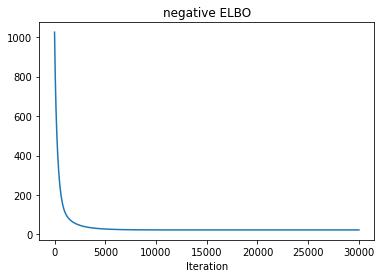

In [15]:
plt.plot(neg_elbo_values)
plt.title("negative ELBO")
plt.xlabel("Iteration")

### Task 1e: Posterior prediction for new data points (1 point)

Under the hood, the algorithm defines a posterior process for all values of the input space.

For a new input $x^*$, the posterior prediction is given by 

$
\begin{align*}
q(f(x^*)) &= \int p(f(x^*)|{\bf f})q({\bf f})d{\bf f}\\
 &= {\cal N}(f(x^*)| K_{f^*{\bf f} }K_{{\bf ff}}^{-1} m_q,
 K_{f^*f^*} - K_{f^*{\bf f}}K_{{\bf ff}}^{-1}(K_{{\bf ff}} - S)K_{{\bf ff}}^{-1}K_{{\bf f} f^*})
\end{align*}
$

where $S$ is the optimized covariance and $\mathbf m_q$ is the optimized mean of $q(\mathbf f)$. Implement this function. 

In [16]:
def kernelmatrix_diagonal_vector(X1, X2, log_ell, log_sigma_squared):
    ell = tf.exp(log_ell)
    sigma_squared = tf.exp(log_sigma_squared)
    #dist_sq = (X1 - X2)**2
    dist_sq = tf.reshape(tf.reduce_sum((X1 - X2)**2, axis=1), [-1,1])
    #dist_sq = tf.reduce_sum(X1**2, axis=1, keepdims=True) + tf.reduce_sum(X2**2, axis=1) - 2 * tf.matmul(X1, X2, transpose_b=True)
    #print(dist_sq.shape)
    #print(X1.shape)
    kernel_matrix = sigma_squared * tf.exp(-dist_sq / (2 * (ell**2)))
    #print(kernel_matrix.shape)
    return kernel_matrix

In [17]:
def posterior_marginal_prediction(X_new, X, m_q, L_q, log_ell, log_sigma_squared):
    """ compute the posterior marginal predictions q(f(x*)) 
    independently for all inputs in X_new 
    
    Note: You need to now use tensorflow functions.
    
    arguments:
    X_new -- N_new × 2, matrix of new inputs
    X     -- N × 2, matrix of training inputs
    m_q   -- N × 1, mean vector of q
    L_q   -- N × N, Cholesky factor of the covariances of q
    log_ell -- log-length-scale of the kernel
    log_sigmasquared -- log-variance of the kernel
    returns: predictive marginal means and variances (both with size N_new × 1)
    """
    ### IMPORTANT
    # We should avoid computing the full N_new × N_new covariance matrix due to memory limitations.
    # You only need the diagonal values of this matrix for the predictive variances.
    # Could you implement an alternative to kernelmatrix() to do this?
    ###############################################
    # ------- insert code here -------------------
    ###############################################

    # compute kernel matrices between training inputs and new inputs

    #S = L_q @ tf.transpose(L_q)
    # S = np.diag(L_q @ np.transpose(L_q))[:, None]
    # compute mean and covariance of the posterior
    # Full matrix version
    #K_f_f = kernelmatrix(X, X, log_ell, log_sigma_squared)
    #K_fstar_f = kernelmatrix(X_new, X, log_ell, log_sigma_squared)
    #K_f_fstar = kernelmatrix(X, X_new, log_ell, log_sigma_squared)
    #K_fstar_fstar = kernelmatrix_diagonal_vector(X_new, X_new, log_ell, log_sigma_squared)
    #print(K_fstar_fstar.shape)
    #m = (K_fstar_f @ tf.linalg.inv(K_f_f)) @ m_q
    #v = tf.reshape(K_fstar_fstar, [-1, 1]) - tf.reshape(tf.linalg.tensor_diag_part(K_fstar_f @ tf.linalg.inv(K_f_f) @ (K_f_f - S) @ tf.linalg.inv(K_f_f) @ K_f_fstar), [-1, 1])
    
    # MODEL SOLUTION #
    
    Kfs = kernelmatrix(X, X_new, log_ell, log_sigma_squared)
    Kff = kernelmatrix(X, X, log_ell, log_sigma_squared)
    Kss = kernelmatrix_diagonal(X_new, log_sigma_squared)
    KffInv_Kfs = tf.linalg.solve(Kff, Kfs)
    m = tf.matmul(KffInv_Kfs, m_q, transpose_a = True)
    S = tf.matmul(L_q, L_q, transpose_b = True)
    v = Kss - tf.reduce_sum(KffInv_Kfs * ((Kff - S) @ KffInv_Kfs), axis=0)[:, None]
    
    return m, v

To test your implementation of `posterior_marginal_prediction`, you can check whether you get back the correct marginals of $q({\bf f})$ when setting `X_new = X`:

In [18]:
def test_marginal_prediction(X, m_q, L_q):
    pred_mean, pred_var = posterior_marginal_prediction(X, X, m_q, L_q, log_ell, log_sigma_squared)
    np.testing.assert_allclose(pred_mean, m_q)
    S_diag = np.diag(L_q @ np.transpose(L_q))[:, None]
    #print(pred_mean.shape)
    #print(m_q.shape)
    #print(pred_var.shape)
    #print(S_diag.shape)
    np.testing.assert_allclose(pred_var, S_diag)

test_marginal_prediction(np.random.randn(5, 1), np.random.randn(5, 1), np.random.randn(5, 5))

For the likelihood
$$ p(y_i|f(\cdot),{\bf x}_i) = p(y_i|f_i) = \phi(y_i * f_i),$$
where $\phi$ is the cdf of the standard normal distribution, the integral $ p(y^*=1 | {\bf y}) \approx \int p(y^*=1 | f^*) q(f^*) \,{\rm d}f^* $
can be solved analytically for Gaussian $q(f^*)$. For $q(f^*) = \mathcal{N}(\mu, \sigma^2)$, we get
$$ \int p(y^* | f^*) q(f^*) \,{\rm d}f^* = \phi(\mu / \sqrt{1 + \sigma^2}) .$$
Alternatively, think about how you can re-use the `expected_log_likelihood` function!

Fill out the implementation of the y output probability given the corresponding GP mean and variance in the plotting code below. After that, try plotting the results!

In [19]:
# create new input points on grid
n_grid = 100
x = np.linspace(XY[:,0].min(), XY[:,1].max(), n_grid)
#print(x.shape)
X1new, X2new = np.meshgrid(x, x)
Xnew = np.hstack([
  X1new.reshape(-1,1), X2new.reshape(-1,1)
])  # size : n_grid * n_grid x 2

#print(X1new.shape)

In [20]:
import time
def plot_posterior(m_new, v_new):
    """
    Plots the posterior prediction for the grid in Xnew (global variable)
    
    arguments:
    m_new -- mean at Xnew
    v_new -- variance at Xnew
    """
    # first, compute marginal posterior over y from the posterior over f:
    ###############################################
    # ------- insert code here -------------------
    ###############################################

    #print(means.shape)
    #print(mvars.shape)
    #time.sleep(30)
    #means, mvars = q_marginals(m_q, L_q)
    #VE = expected_log_likelihood(means, mvars, classif_log_likelihood, y, n_gh=20)
    Ypred = tf.divide(m_new, tf.sqrt(1 + tf.square(v_new)))
    #print(Ypred.shape)
    # y_new = expected_log_likelihood(m_new, v_new, classif_log_likelihood, Ypred, n_gh=20)
    # Model solution
    y_new = expected_log_likelihood(m_new, v_new, lambda f, _: phi(f), None)[:, None]
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.contour(x, x, m_new.numpy().reshape(n_grid,n_grid),
                cmap=plt.cm.RdBu_r, vmin=-np.abs(m_new).max(), vmax=np.abs(m_new).max())
    plt.colorbar()
    plt.title("Posterior mean")
    plt.subplot(1,3,2)
    plt.contour(x, x, v_new.numpy().reshape(n_grid,n_grid))
    plt.colorbar()
    plt.title("Posterior variance")
    plt.subplot(1,3,3)
    plt.contour(x, x, y_new.numpy().reshape(n_grid,n_grid),
                cmap=plt.cm.RdBu_r, vmin=0, vmax=1)
    plt.colorbar()
    plt.title("p(y|f)")
    plt.scatter(X[:,0], X[:,1], c=Y)  # training points

    #plt.scatter(XY[:,0], XY[:,1], c=XY[:,2], s=1, alpha=0.3)  # all data points
    plt.xlim(x.min(), x.max())
    plt.ylim(x.min(), x.max())

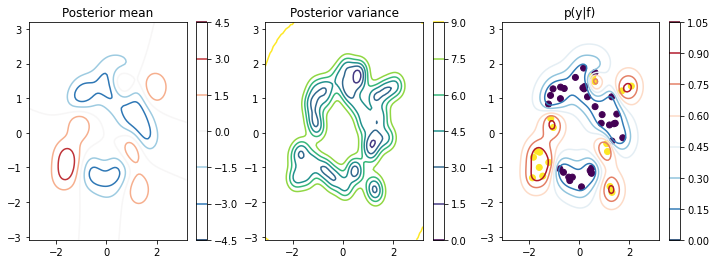

In [21]:
###############################################
# ------- insert code here -------------------
###############################################
#m_new, v_new = np.mean(Xnew, axis=1).reshape(-1, 1), kernelmatrix_diagonal(Xnew, Xnew, log_ell, log_sigma_squared)
#ell = 0.5  # the length scale
#sigma_squared = 3.0**2  # the kernel variance
#m_q, L_q, neg_elbo_values, log_ell, log_sigma_squared = optimize_elbo(ell, sigma_squared, optimize_hyperparams=True, print_progress=False)
m_new, v_new = posterior_marginal_prediction(Xnew, X, m_q, L_q, log_ell, log_sigma_squared)
#print(m_new.shape)
#print(v_new.shape)
plot_posterior(m_new, v_new)

### Task 1f: Repeat with different hyperparameter values! (1 Point)
* Repeat the procedure for different values of $(\ell, \sigma^2)$, aside from $(0.5, 9)$. Can you see improvements or worse results? Does the ELBO correlate with good hyperparameter values in this example?
* Repeat the procedure, but this time setting optimize_hyperparameters=True and actually optimize the hyperparameters. Is the reached ELBO better than the values you got from the previous runs?

In [22]:
def optimize_elbo_new(ell, sigma_squared, optimize_hyperparams=False, print_progress=True):
    """ Optimize the variational posterior q(f) and (optionally) the length scale and variance hyperparameters.
    
    Arguments:
    ell -- The kernel effective length scale, or its initial value in case optimize_hyperparameters=True
    sigma_squared -- The kernel variance, or its initial value in case optimize_hyperparameters=True
    optimize_hyperparams -- Whether to optimize hyperparameters
    print_progress -- Whether to print out ELBO values during optimization
    
    Returns:
    m_q -- The mean vector of the optimized variational posterior
    L_q -- the Cholesky factor L_q of the covariance of the optimized variational posterior
    elbo_values -- The intermediate values of the ELBO during optimization
    log_ell -- The log effective length scale after optimization
    log_sigma_squared -- The log kernel variance after optimization
    """
    
    # Log-hyperparameters:
    v_log_ell = tf.Variable(np.log(ell), dtype=tf.float64)
    v_log_sigma_squared = tf.Variable(np.log(sigma_squared), dtype=tf.float64)
    
    # The prior mean and the Cholesky factor of the prior covariance
    K_p = kernelmatrix(X, X, v_log_ell, v_log_sigma_squared)
    m_p = tf.Variable(np.zeros((N, 1)), dtype=tf.float64)
    L_p = tf.linalg.cholesky(K_p)
    #print(K_p.shape)
    #print(m_p.shape)
    #print(L_p.shape)
    # Initial distribution parameters m_q, L_q
    m_q = tf.Variable(np.zeros((N, 1)), dtype=tf.float64)
    # As Cholesky factors are lower triangular with positive diagonals, we want to parametrize them as such. 
    # Here we use tfp.bijectors.FillTriangular to map the trainable parameters in L_q_params
    # to a lower-triangular matrix and tfp.bijectors.TransformDiagonal to map the diagonals to positive values.
    # L_q is initialized at the identity matrix (note the exp transform for the diagonals)
    # Could also initialize to np.linalg.cholesky(K_p) for potentially faster convergence.
    L_q_params = tf.Variable(tfp.math.fill_triangular_inverse(np.zeros((N,N))), dtype=tf.float64)
    filltriangular = tfp.bijectors.FillTriangular(upper=False)
    positivediagonal = tfp.bijectors.TransformDiagonal(diag_bijector=tfp.bijectors.Exp())
    transform = lambda x: positivediagonal(filltriangular(x))
    
    # Loss function if we don't do hyperparameter optimization
    loss_q = lambda: - elbo(m_p, L_p, m_q, transform(L_q_params), Y)
    # Loss function for hyperparameter optimization (the prior Cholesky factor changes at each step)
    loss_hp = lambda: - elbo(m_p, tf.linalg.cholesky(kernelmatrix(X, X, v_log_ell, v_log_sigma_squared)), m_q, transform(L_q_params), Y)

    # definition of a training step
    def create_train_step(loss, opt, trainable_variables):
        @tf.function  # this makes the optimisation loop much faster, but restricts what operations you can do within your code
        def train_step():
            with tf.GradientTape() as tape:
                tape.watch(trainable_variables)
                loss_value = loss()
            gradients = tape.gradient(loss_value, trainable_variables)
            opt.apply_gradients(zip(gradients, trainable_variables))
            return loss_value
        return train_step

    # you can change the optimizer or learning rate
    opt = tf.optimizers.Adam(learning_rate=0.001) 

    num_iterations = 2000 # you can change the number of steps as well

    loss = loss_hp if optimize_hyperparams else loss_q
    trainable_variables = [m_q, L_q_params, v_log_ell, v_log_sigma_squared] if optimize_hyperparams else [m_q, L_q_params]
    train_step = create_train_step(loss, opt, trainable_variables)
    neg_elbo_values = []
    # running the optimization
    for t in range(num_iterations):
        neg_elbo_value = train_step()
        neg_elbo_values.append(neg_elbo_value)
        if t % 500 == 0 and print_progress:
            print(t, loss().numpy())
    L_q = transform(L_q_params)
    return m_q, L_q, neg_elbo_values, v_log_ell, v_log_sigma_squared

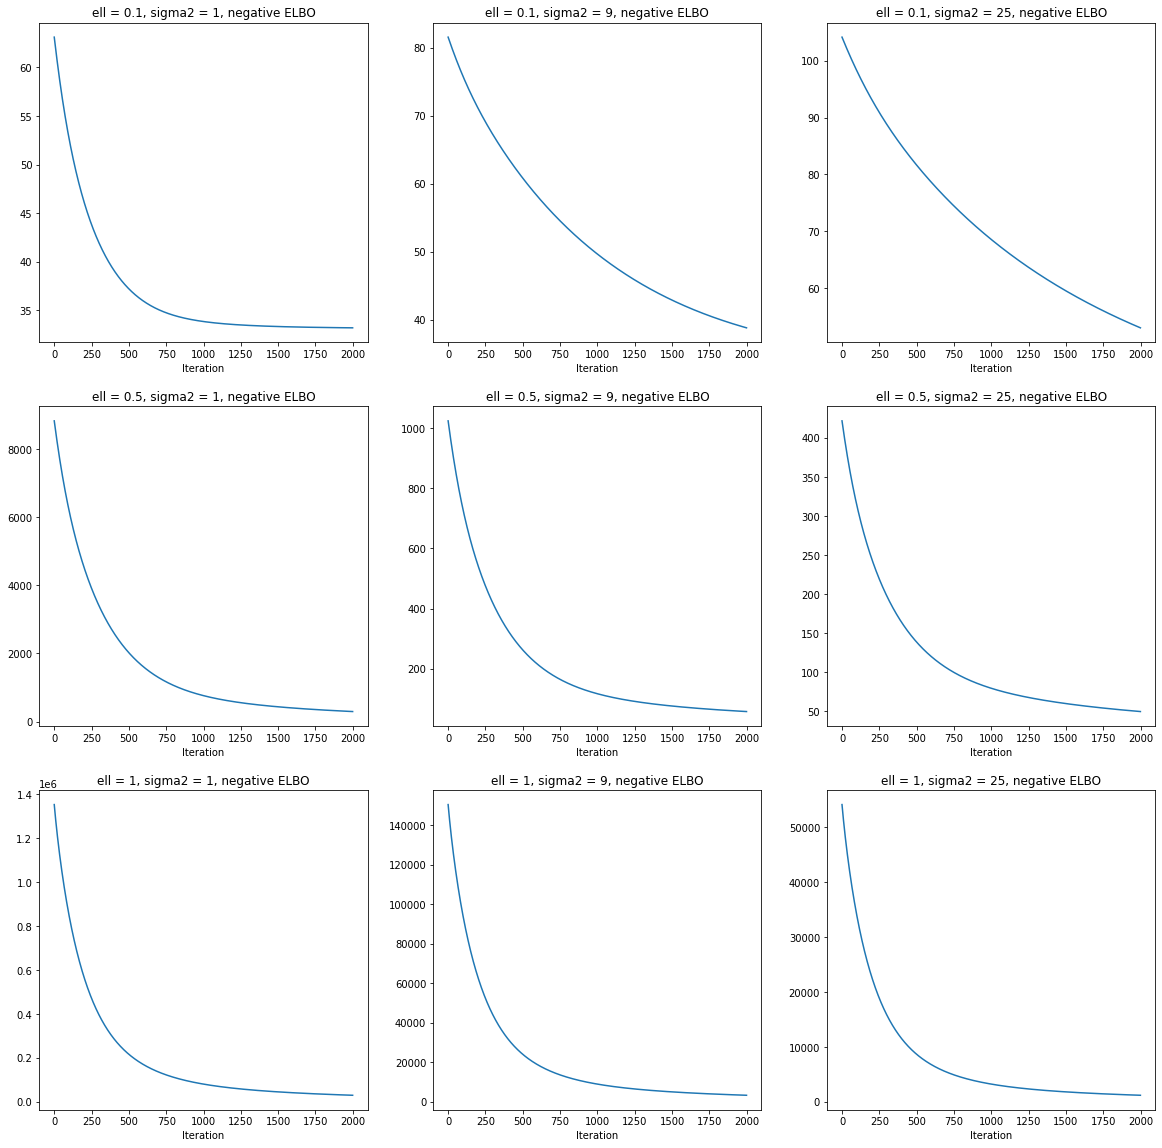

In [23]:
fig,ax=plt.subplots(nrows=3, ncols=3, figsize=(20, 20))
ells = [0.1, 0.5, 1]  # the length scale
sigma_squareds = [1**2, 3**2, 5**2]  # the kernel variance

for indexEll, ell in enumerate(ells):
    for indexSigma, sigma_squared in enumerate(sigma_squareds):
        m_q, L_q, neg_elbo_values, log_ell, log_sigma_squared = optimize_elbo_new(ell, sigma_squared, optimize_hyperparams=False, print_progress=False)
        ax[indexEll][indexSigma].plot(neg_elbo_values)
        ax[indexEll][indexSigma].set_title(f"ell = {ell}, sigma2 = {sigma_squared}, negative ELBO")
        ax[indexEll][indexSigma].set_xlabel("Iteration")

=> The ELBO really correlates with good hyperparameter values in this example. It can be seen that the optimal hyperparameter values among the figures is ell = 1 and sigma_squared = 1

The optimal hyperparameter ell value: 0.7398657128106485
The optimal hyperparameter sigma2 value: 35.8414175359965


Text(0.5, 0, 'Iteration')

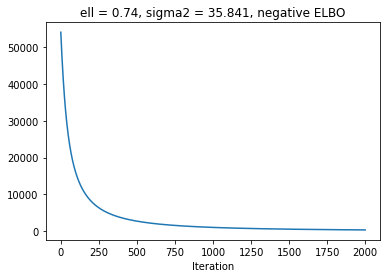

In [24]:
m_q, L_q, neg_elbo_values, log_ell, log_sigma_squared = optimize_elbo_new(ell, sigma_squared, optimize_hyperparams=True, print_progress=False)
print("The optimal hyperparameter ell value:", np.exp(log_ell))
print("The optimal hyperparameter sigma2 value:", np.exp(log_sigma_squared))
plt.plot(neg_elbo_values)
plt.title(f"ell = {round(np.exp(log_ell),3)}, sigma2 = {round(np.exp(log_sigma_squared),3)}, negative ELBO")
plt.xlabel("Iteration")

Conclusion: the reached ELBO is much better than the values from the previous runs, where the rate of convergence is the most rapid. 